# Think Like a Machine - Chapter 6
Non-Linear Logistic Regression (and Regularization)
===============================

**ACKNOWLEDGEMENT**

**A lot of the code in this notebook is from John D. Wittenauer's notebooks that cover the exercises in Andrew Ng's course on Machine Learning on Coursera. This is mostly Wittenauer's and Ng's work and acknowledged as such. I've also used some code from Sebastian Raschka's book *Python Machine Learning*. **

## The Problem
You're in charge of Quality Assurance at a semiconductor manufacturing plant. You have the data on a sample of microchips that have each been through two tests. You have the two scores for each microchip in the sample. In addition, based on the scores, you have labels for each microchip on whether it was accepted or rejected. Your goal is to determine if a new microchip that's been tested should be accepted or rejected based on the scores it receives.

The structure of this problem is the same as the one we had in the previous chapter. The difference is in the data. Let's take a look at it asap.

In [467]:
# Use the functions from another notebook in this notebook
%run SharedFunctions.ipynb

In [468]:
# Import our usual libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Load the Data

In [469]:
import os
path = os.getcwd() + '/Data/ex2data2.txt'
data2 = pd.read_csv(path, header=None, names=['Test 1', 'Test 2', 'Accepted'])
data2.head()

,Test 1,Test 2,Accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [470]:
data2.shape

(118, 3)

We have 118 rows of data in our dataset.

## Visualize the Data

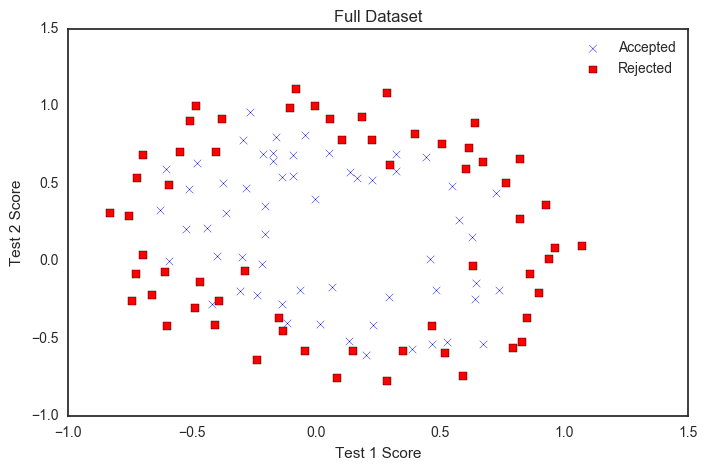

In [471]:
positive = data2[data2['Accepted'].isin([1])]
negative = data2[data2['Accepted'].isin([0])]

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(positive['Test 1'], positive['Test 2'], s=30, c='b', marker='x', label='Accepted')
ax.scatter(negative['Test 1'], negative['Test 2'], s=30, c='r', marker='s', label='Rejected')
ax.legend()
ax.set_xlabel('Test 1 Score')
ax.set_ylabel('Test 2 Score')
ax.set_title('Full Dataset')

Notice something immediately? There's no way to draw a line to separate the blue Xes from the red squares. The decision boundary needs to be a curve which means this is a non-linear problem. We're going to "manufacture" a number of new features in order to tackle this problem. You'll see that it's not hard to draw non-linear boundaries; but it's much harder to draw a non-linear boundary and still have a useful model with which to make predictions -- predictions about the future, as Yogi Berra would say. Regularization is the technique for making sure that complex models with non-linear decision boundaries can still be useful.

Instead of getting ahead of ourselves, let's take this step by step.

## Steps 1 and 2: Define the Inputs and Outputs by Splitting the Dataset Into Training and Test Datasets


We'll see why this split makes sense a bit later, but for now, let's split our one dataset into two datasets -- one with 80% of the original data (the Training set) and the other with 20% of the original data (the Test set).

In [472]:
# Split the data into Training and Test (80-20 split into training and test sets)
from sklearn.model_selection import train_test_split
X = data2.iloc[:, 0:2].values
y = data2.iloc[:, 2].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [473]:
X_test

array([[-0.21947  , -0.016813 ],
       [-0.38076  ,  0.91886  ],
       [-0.51325  ,  0.46564  ],
       [ 0.57546  ,  0.26827  ],
       [ 0.46601  , -0.53582  ],
       [-0.0063364,  0.99927  ],
       [ 0.86348  , -0.082602 ],
       [ 0.38537  , -0.56506  ],
       [-0.50749  ,  0.90424  ],
       [ 0.79435  , -0.55775  ],
       [-0.17339  ,  0.69956  ],
       [-0.72638  , -0.082602 ],
       [ 0.52938  , -0.5212   ],
       [ 0.28744  ,  1.087    ],
       [ 0.64459  , -0.14108  ],
       [-0.16187  ,  0.8019   ],
       [-0.4038   ,  0.70687  ],
       [ 0.051267 ,  0.69956  ],
       [ 0.39689  ,  0.82383  ],
       [-0.66302  , -0.21418  ],
       [ 0.76555  ,  0.50219  ],
       [ 0.2932   , -0.2288   ],
       [-0.081221 ,  1.1089   ],
       [-0.20795  ,  0.35599  ]])

### Visualize the Training Data

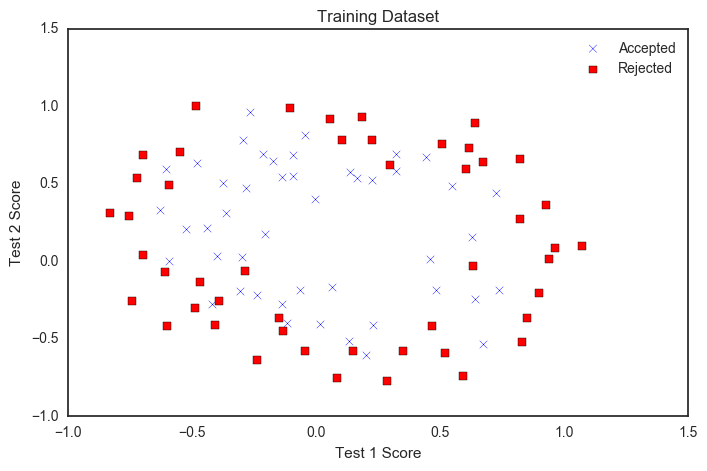

In [474]:
# Bring the training inputs and training outputs together
#X_train.shape
#y_train.shape
training_data = np.c_[X_train, y_train]

# Get all inputs that have positive outputs -- i.e., Accepted
pos_train_inputs = np.array([tr_d for tr_d in training_data if tr_d[2] == 1])[:,0:2]
#pos_train_inputs

# Get all the inputs that have negative outputs -- i.e., Rejected
neg_train_inputs = np.array([tr_d for tr_d in training_data if tr_d[2] == 0])[:,0:2]
#neg_train_inputs

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(pos_train_inputs[:,0], pos_train_inputs[:,1], s=30, c='b', marker='x', label='Accepted')
ax.scatter(neg_train_inputs[:,0], neg_train_inputs[:,1], s=30, c='r', marker='s', label='Rejected')
ax.legend()
ax.set_xlabel('Test 1 Score')
ax.set_ylabel('Test 2 Score')
ax.set_title('Training Dataset')

The training dataset looks just like the full dataset -- it just contains fewer data points.

### Visualize the Test Data

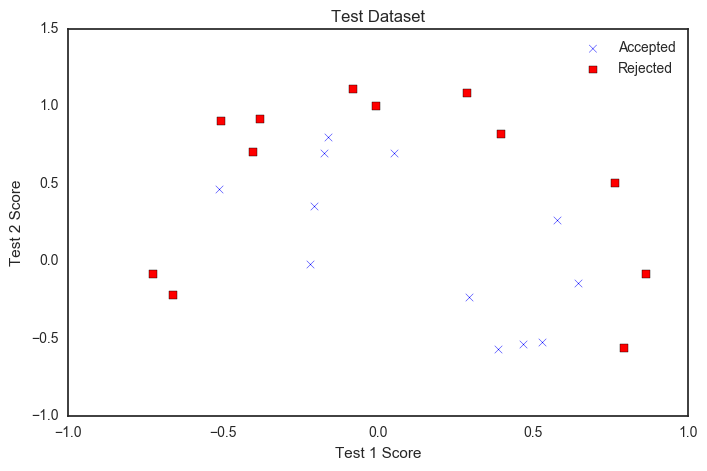

In [475]:
# Bring the test inputs and test outputs together
#X_test.shape
#y_test.shape
test_data = np.c_[X_test, y_test]

# Get all inputs that have positive outputs -- i.e., Accepted
pos_test_inputs = np.array([t_d for t_d in test_data if t_d[2] == 1])[:,0:2]
#pos_test_inputs

# Get all the inputs that have negative outputs -- i.e., Rejected
neg_test_inputs = np.array([t_d for t_d in test_data if t_d[2] == 0])[:,0:2]
#neg_test_inputs

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(pos_test_inputs[:,0], pos_test_inputs[:,1], s=30, c='b', marker='x', label='Accepted')
ax.scatter(neg_test_inputs[:,0], neg_test_inputs[:,1], s=30, c='r', marker='s', label='Rejected')
ax.legend()
ax.set_xlabel('Test 1 Score')
ax.set_ylabel('Test 2 Score')
ax.set_title('Test Dataset')

The test dataset looks a lot sparser than the full dataset. There's good reason for that which we'll get to later in this chapter.

## Step 3: Define the Model
We only have two inputs -- scores in tests 1 and 2. However, we need a non-linear decision boundary between the microchips that are accepted versus those that are rejected. The only way to do this is to manufacture more features based on the two features we already have.

To make a point, we're going to go crazy with the manufacturing of features. In fact, our model will be a sixth-degree polynomial. The image below shows how to systematically construct the factors of an nth-order polynomial.

![making a 6-th order polynomial](Images/sixth-order-factors.jpg "Sixth-Order Factors")

[[WRITE OUT THE MODEL]]

In [476]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(6)
X_train_poly6 = poly.fit_transform(X_train)
X_test_poly6 = poly.fit_transform(X_test)
# NOTE: the poly function adds a bias value of 1 to each row of input data -- default include_bias=True

In [477]:
X_train_poly6.shape

(94, 28)

In [478]:
X_train.shape

(94, 2)

We've increased the number of features from 2 to 28 by using a 6th degree polynomial. Let's use logistic regression to solve the problem.

## Steps 4 - 7: Set Up and Implement the Model

We've made the inputs very complicated -- so before we implement a logistic regression algorithm that depends on some form of gradient descent to find its solution, let's normalize our inputs so that the algorithm can operate efficiently.

In [479]:
# first row of the training inputs
X_train_poly6[0]

array([  1.00000000e+00,   6.27300000e-01,   1.58630000e-01,
         3.93505290e-01,   9.95085990e-02,   2.51634769e-02,
         2.46845868e-01,   6.24217442e-02,   1.57850491e-02,
         3.99168234e-03,   1.54846413e-01,   3.91571601e-02,
         9.90196127e-03,   2.50398233e-03,   6.33200570e-04,
         9.71351550e-02,   2.45632865e-02,   6.21150031e-03,
         1.57074812e-03,   3.97206717e-04,   1.00444606e-04,
         6.09328828e-02,   1.54085496e-02,   3.89647414e-03,
         9.85330294e-04,   2.49167774e-04,   6.30089016e-05,
         1.59335279e-05])

In [480]:
# Implement logistic regression using Scikit Learn
# Large C means low regularization lambda; Small C means high regularization lambda
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score

lr = LogisticRegression(solver='newton-cg', C=10000)
lr.fit(X_train_poly6, y_train)

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)

In [481]:
# Classification accuracy on the training data
lr.score(X_train_poly6, y_train)

0.86170212765957444

In [482]:
# How did this classifier do on the test data?
predicted = lr.predict(X_test_poly6)
print metrics.accuracy_score(y_test, predicted)
print metrics.roc_auc_score(y_test, predicted)

0.791666666667
0.791666666667


In [483]:
lr.intercept_

array([ 2.56045584])

In [484]:
# The optimal values of theta
lr.coef_

array([[  0.30886575,  -0.55695528,   1.3268363 , -12.4887436 ,
         -7.82652801,   3.36017668,   1.16851908,  29.8610121 ,
         14.48806388,  10.54733885,  42.33055754,   4.42352696,
         -7.48201067,  -8.14742437, -25.94221129,  10.59686514,
        -37.57938855,  22.87060248, -17.28254098, -10.97649732,
         -2.35294178, -66.50503289, -11.27307917, -27.72161858,
         22.70523796, -37.22761294, -32.11814358,   3.42408937]])

In [485]:
# Sanity checks
m = X_train_poly6.shape[0]
print 'Number of samples:', m
print 'lr.coef_ shape:', lr.coef_.shape
# Multiply the inputs by the coefficients to get the optimal cost
print 'X_train_poly6 shape:', X_train_poly6.shape
dotProd = sigmoid(np.matrix(X_train_poly6) * np.matrix(lr.coef_).T)
cost_first_term = np.multiply(-y_train.reshape(94,1), np.log(dotProd))
cost_second_term = np.multiply(np.subtract(1,y_train.reshape(94,1)),np.log(np.subtract(1, dotProd)))
non_reg_cost = np.divide(np.sum(np.subtract(cost_first_term, cost_second_term)), m)
print 'Optimal Non-Regularized Cost:', non_reg_cost

# Regularize the cost
Lambda = 100.
theta_squared = np.square(lr.coef_)
theta_squared[0,0] = 0
reg_theta = np.sum(theta_squared)
reg_term = np.divide(Lambda,np.multiply(2,m))
print 'Regularization Term:', reg_term
reg_cost = np.add(non_reg_cost, reg_term)
print 'Regularized Cost:', reg_cost

Number of samples: 94
lr.coef_ shape: (1, 28)
X_train_poly6 shape: (94, 28)
Optimal Non-Regularized Cost: 0.63654066984
Regularization Term: 0.531914893617
Regularized Cost: 1.16845556346


In [486]:
# Contour plot of the decision boundary
# Make grid values
xx1, xx2 = np.mgrid[-1:1.5:.02, -1:1.5:.02]

In [487]:
xx1

array([[-1.  , -1.  , -1.  , ..., -1.  , -1.  , -1.  ],
       [-0.98, -0.98, -0.98, ..., -0.98, -0.98, -0.98],
       [-0.96, -0.96, -0.96, ..., -0.96, -0.96, -0.96],
       ..., 
       [ 1.44,  1.44,  1.44, ...,  1.44,  1.44,  1.44],
       [ 1.46,  1.46,  1.46, ...,  1.46,  1.46,  1.46],
       [ 1.48,  1.48,  1.48, ...,  1.48,  1.48,  1.48]])

In [488]:
xx2

array([[-1.  , -0.98, -0.96, ...,  1.44,  1.46,  1.48],
       [-1.  , -0.98, -0.96, ...,  1.44,  1.46,  1.48],
       [-1.  , -0.98, -0.96, ...,  1.44,  1.46,  1.48],
       ..., 
       [-1.  , -0.98, -0.96, ...,  1.44,  1.46,  1.48],
       [-1.  , -0.98, -0.96, ...,  1.44,  1.46,  1.48],
       [-1.  , -0.98, -0.96, ...,  1.44,  1.46,  1.48]])

In [489]:
# Create the grid
grid = np.c_[xx1.ravel(), xx2.ravel()]
grid.shape

(15625, 2)

In [490]:
# Get the probabilities for each grid value
# Note: Make sure it's transformed so 
probs = lr.predict_proba(poly.fit_transform(grid))
probs.shape

(15625, 2)

In [491]:
probs_bin = lr.predict(poly.fit_transform(grid))
probs_bin.shape

(15625,)

In [492]:
grid.shape

(15625, 2)

In [493]:
probs_to_binary = []
for prob in probs:
    if prob[1] > 0.5:
        probs_to_binary.append(1)
    else:
        probs_to_binary.append(0)

In [494]:
(probs_to_binary != np.zeros(15625)).sum()

4237

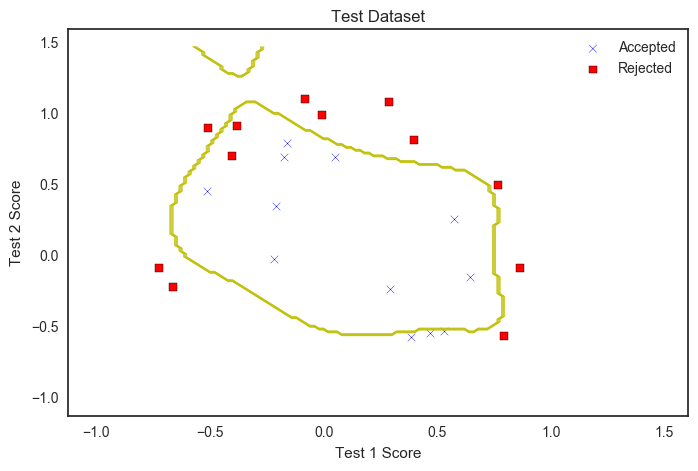

In [495]:
#plt.contour(xx1,xx2,np.array(probs_to_binary).reshape(xx1.shape))
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(pos_test_inputs[:,0], pos_test_inputs[:,1], s=30, c='b', marker='x', label='Accepted')
ax.scatter(neg_test_inputs[:,0], neg_test_inputs[:,1], s=30, c='r', marker='s', label='Rejected')
ax.legend()
ax.set_xlabel('Test 1 Score')
ax.set_ylabel('Test 2 Score')
ax.set_title('Test Dataset')
plt.contour(xx1,xx2,probs_bin.reshape(xx1.shape), colors='y', linewidths=0.5)

## Results

[[To Come]]

# Appendix

[(-5, 5),
 (-5, 5),
 None]

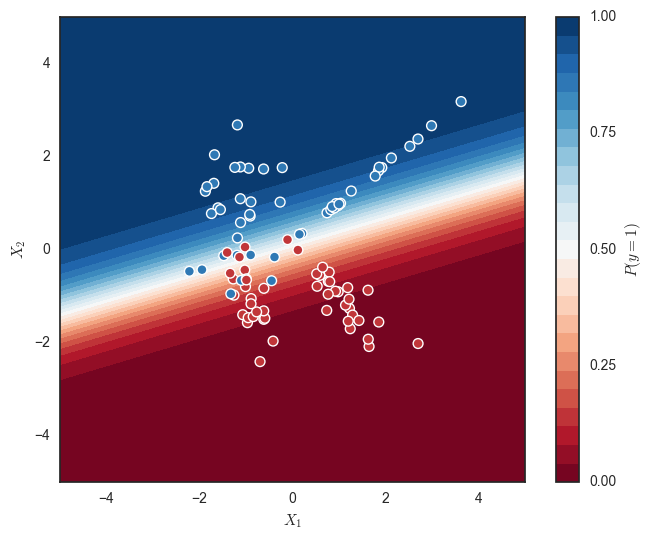

In [496]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")

X, y = make_classification(200, 2, 2, 0, weights=[.5, .5], random_state=15)
clf = LogisticRegression().fit(X[:100], y[:100])

xx, yy = np.mgrid[-5:5:.01, -5:5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = clf.predict_proba(grid)[:, 1].reshape(xx.shape)

f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(aspect="equal",
       xlim=(-5, 5), ylim=(-5, 5),
       xlabel="$X_1$", ylabel="$X_2$")